In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import ast
from ast import literal_eval

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression



from datetime import datetime

# ORGANISATION
- classification - alicia / maria 
- temporal evolution - anissa 
- majoritiy representation - virginie
- climate speaking proprotion - virginie 
- sentiment analysis - alicia / maria 
- readme data,set  - virginie
- readme methodes - alicia / maria 
- data story (site web) - anissa

- [doing] CLASSIFICATION - Based on the evolution of the profile of a person talking about climate in the media, can we predict what characteristics will a climate-involved person have in the future ? 
 
 - [doing] TEMPORAL EVOLUTION - Is there any temporal evolution in the mediatic coverage of the climate crisis ? If so, does it correlate with specific events ? 
 
 - [doing] MAJORITY REPRESENTATION - Who are the top 10 people that talks the most about climate change over the year ? Does it show an evolution in the general opinions made publicly avaiblable by mainstream media ? What is the current typical profile of a person talking about climate in the media ? Is it the same for other topic ? (Comparaison entre les caractéristiques de personnes les plus représentées dans le QuoteBank vs celles qui parlent du climat) (comparaison des nationalités avec une carte du monde) 
 
 - [x] CLIMATE SPEAKING PROPORTION - Are some communities excluded from the mediatic discussion surround climate change ? (Comparer la proportion de chacun des communautés dans QB en général avec la propotion des communautés dans les phrases qui parlent du climat) - plot climate vs non climate 
 
 - [x] NLP TOPIC CLASSIFICATION - What is the most represented climate crisis-related topic along the years ? Does it show an evolution in the general opinions made publicly avaiblable by mainstream media ? (Trouver les mots reliés au climat les plus représentés dans les quotes chaque années) 

- [x] SENTIMENT ANALYSIS - Vander Analysis among people that talks about climate

# A RUN POUR AVOIR SUBDATA (Year-month)

In [37]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes.

In [38]:
subdata=pd.DataFrame()
for years, quotes in dico_clean.items() : 
    subdata = pd.concat([subdata, quotes])

In [39]:
subdata.date.map(lambda y : datetime.strptime(y, '%Y-%m-%d %H:%M:%S'))
subdata.sort_values(by='date', inplace=True)
subdata['date'] = pd.to_datetime(subdata['date']).dt.strftime('%Y-%m')

# Temporal Evolution - ANISSA

> Years and month 

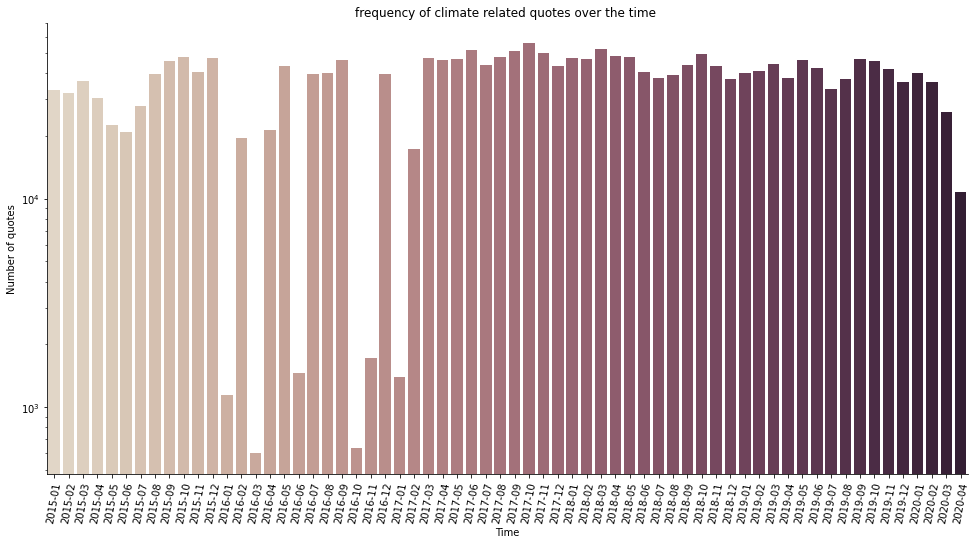

In [5]:
ax=sns.catplot(data=subdata, x = 'date',  kind="count", 
               palette="ch:.25",height=7, aspect=2)
ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the time ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

> Years

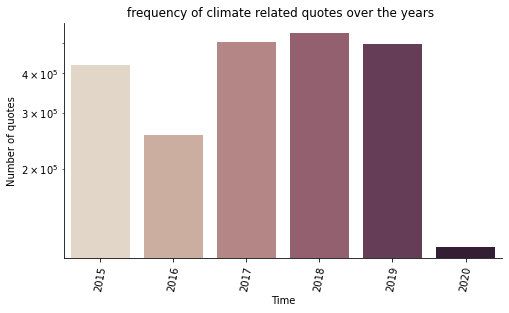

In [6]:
subdata_years = subdata.copy()
subdata_years['date'] = pd.to_datetime(subdata_years['date']).dt.strftime('%Y')


ax=sns.catplot(data=subdata_years, x = 'date',  kind="count", 
               palette="ch:.25",height=4, aspect=1.8)

ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the years ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

# Majority representation - VIRGINIE

In [ ]:
top_10 = subdata.copy()
speaker_time = top_10[['speaker','date','numOccurrences']]
count_top_10 = speaker_time.groupby('speaker')['numOccurrences'].agg(['count']).sort_values('count', ascending=False).head(10)

In [ ]:
count_top_10

In [ ]:
speaker_list = speaker_time['speaker'].tolist()

x = 0 
big_ls = []

for i in count_top_10.index:
    ls = []
    x = x+1
    if i in speaker_list:
        ls.append(speaker_time['date'])
        big_ls.append(ls)

count_top_10['date'] = big_ls
count_top_10

In [ ]:
x_speaker = count_top_10.index.tolist()
y_count = count_top_10['count']

count_top_10.plot.bar()

# Climate speaking proprotion - VIRGINIE

# NLP - Sentiment Analysis

We have now a good visualization about climate speaker representation. But we can wonder on the general feelings expressed among these quotes. How do people talk about it? Can we extract some intersting pattern.

In [2]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models as gensimvis

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
#declaration of analyzer function
analyzer = SentimentIntensityAnalyzer()

In [4]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_csv(f"data/clean_quotes-{date}.bz2", compression = 'bz2')

In [5]:
dico_quotes = {} #We create a dictonary that contains each quotations that are talking about climate for ever year 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_quotes[date] = dico[date]['quotation']

## Distributions

### Positive and negative rates distributions through the years

In [ ]:
positive_sent = {}
negative_sent = {}


#iterate through the sentencs, get polarity scores, choose a value

for key, quotes in dico_quotes.items():
    ls_pos = []
    ls_neg = []
    for quote in quotes: 
        ls_pos.append(analyzer.polarity_scores(quote)['pos'])
        ls_neg.append(analyzer.polarity_scores(quote)['neg'])
    positive_sent[key] = ls_pos
    negative_sent[key] = ls_neg

In [ ]:
def get_above_zero(my_list): #function to remove the feeling rates that equal exactly to zero as they were outliers
    np_arr = np.array(my_list)
    return np_arr[np_arr > 0]

In [ ]:
def get_under_n(my_list,n): #function to remove the feeling rates that equal exactly to zero as they were outliers
    np_arr = np.array(my_list)
    return np_arr[np_arr < 0.45]

In [ ]:
#plotting positive and negative sentiment rates of the quotes across time
fig, axes = plt.subplots(3,2, figsize=(15,15))
i=0

for date in [2020, 2019, 2018, 2017, 2016, 2015]:

    ls_pos = get_above_zero(positive_sent[date])
    ls_neg = get_above_zero(negative_sent[date])
    #we decided to removed the values over 0.45 as we considered them as outliers 
    ls_pos = get_under_n(ls_pos,0.45)
    ls_neg = get_under_n(ls_neg,0.45)
    line, col = divmod(i, 2)
    sns.boxplot(data = [ls_pos,ls_neg], orient = "h", ax = axes[line,col],showfliers=True, palette = 'colorblind').set(title = f'Positive and negative distributions in the {date} quotes', xlabel='rates', ylabel='sentiments')
    axes[line,col].set_yticklabels(['pos','neg'])
    i = i+1

## A comparison of the two main politic party

In [58]:
subdata

,quoteID,quotation,speaker,qids,date,numOccurrences
43960,2015-01-01-037433,We knew going into the game that Glasgow are a...,Jack Cuthbert,['Q6111953'],2015-01,1
18610,2015-01-01-014223,"I'd like to thank my teammates, coaches and ou...",Justin Houston,['Q12060573'],2015-01,1
12414,2015-01-01-036860,We have a Government now whose economic policy...,Jeanette Fitzsimons,['Q444691'],2015-01,2
42279,2015-01-01-014311,"If climate justice was lightning, then we woul...",Ban Ki-moon,['Q1253'],2015-01,1
14484,2015-01-01-041705,"You and I like the low gas prices, but you rea...",Joe Pickett,['Q16187264'],2015-01,1
...,...,...,...,...,...,...
4116,2020-04-16-008226,"Climate change, in other words, may make the d...",Marco Tedesco,['Q58222223'],2020-04,1
14313,2020-04-16-020492,"I think that my being Irish American, the gran...",Elizabeth Dennehy,['Q529120'],2020-04,1
16498,2020-04-16-035871,On Monday I went to the McDonalds drive throug...,Peter Baldacchino,['Q15840025'],2020-04,1
1248,2020-04-16-039463,Rhode Island is especially vulnerable to the e...,Peter Kilmartin,['Q7175189'],2020-04,1


In [81]:
speaker = pd.read_csv('data/one_hot.bz2', compression='bz2')

In [85]:
speaker.columns = speaker.columns.str.replace("[',']", '')

In [86]:
speaker

,date_of_birth,label,climate,[association football player],[politician],[actor],[writer],[researcher],[painter],[visual artist],...,[transgender female male],[transgender female female],[intersex non-binary],[genderqueer],[cisgender female],[intersex female],[male transgender female],[female non-binary],[transgender person],[cisgender male]
0,1952,Douglas Adams,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,George W. Bush,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,Neil Young,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1969,Harald Krichel,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1932,Andrei Tarkovsky,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895031,1960,Michael Felix Suarez,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2895032,2002,Moameen Mutasem,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2895033,1952,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2895034,1926,John Nolan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
republicans_climate = speaker[['[Republican Party]','label']]
democratic_climate = speaker[['[Democratic Party]','label']]

In [108]:
def quotes_politics(list): 
    template=[] 
    for n in list: 
        template.append(subdata.loc[(subdata["speaker"].apply(lambda x : n in str(x).split(' ')) )])
    return pd.concat(template, ignore_index=True)# return a dataframe with our data of interest

In [112]:
def quotes_sentiments(list): 
    ls_pos = []
    ls_neg = []
    for n in list: 
        ls_pos.append(analyzer.polarity_scores(n)['pos'])
        ls_neg.append(analyzer.polarity_scores(n)['neg'])
        
    return ls_pos,ls_neg      

In [109]:
df_demo = quotes_politics(democratic_climate[democratic_climate['[Democratic Party]'] == 1]['label'])
df_repu = quotes_politics(republicans_climate[republicans_climate['[Republican Party]'] == 1]['label'])

In [114]:
ls_pos_rep, ls_neg_rep = quotes_sentiments(df_repu['quotation'])
ls_pos_dem, ls_neg_dem = quotes_sentiments(df_demo['quotation'])

[Text(0, 0, 'rep'), Text(0, 1, 'dem')]

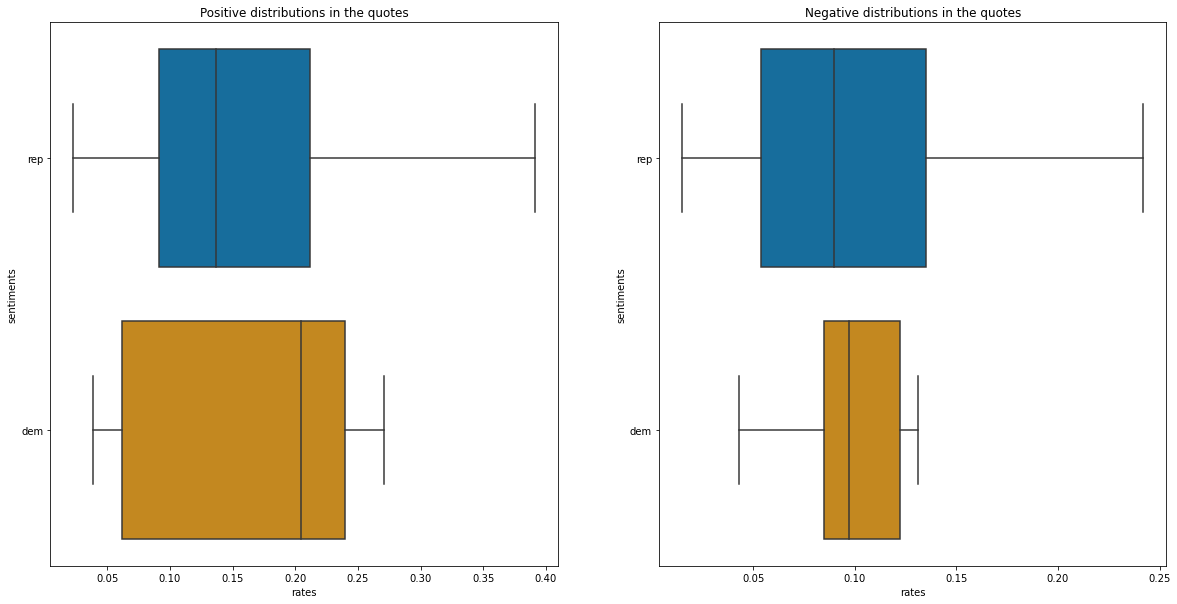

In [141]:
fig, axes = plt.subplots(1,2, figsize=(20,10))


to_plot = [get_above_zero(ls_pos_rep),get_above_zero(ls_pos_dem)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[0],showfliers=False, palette = 'colorblind').set(title = 'Positive distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[0].set_yticklabels(['rep','dem'])

to_plot = [get_above_zero(ls_neg_rep),get_above_zero(ls_neg_dem)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[1],showfliers=False, palette = 'colorblind').set(title = 'Negative distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[1].set_yticklabels(['rep','dem'])